In [1]:
!pip install xlearn -q

In [2]:
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt 
from fastprogress.fastprogress import progress_bar
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
import datetime as dt
import os
import xlearn as xl

%matplotlib inline
warnings.filterwarnings('ignore')
os.environ['USER'] = 'xlearn'

In [3]:
path_to_data = '../input/recsys/data.csv'

In [4]:
data = pd.read_csv(path_to_data)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [5]:
data.describe()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582140e+07,1.582140e+07,1.582140e+07,1.582147e+07,1.580173e+07,1.580173e+07,1.580173e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,4.610505e+18,6.238540e-01,1.840605e+00,4.346986e+00,6.571314e+05,1.969248e-01,7.440764e-01,-3.979590e+00,2.605069e+06,1.415899e+00,5.485722e-01,-3.968883e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,2.663858e+18,9.249152e+00,1.530005e+00,4.317701e+00,2.606008e+06,2.733440e+00,1.670358e+01,1.143982e+00,5.230253e+06,8.689053e+00,1.419136e+01,1.186403e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.763740e-02,-8.588970e+00,0.000000e+00,0.000000e+00,-6.983897e-02,-9.562188e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,2.297977e+18,0.000000e+00,1.000000e+00,0.000000e+00,7.300000e+01,5.000000e-03,1.643856e-02,-4.515871e+00,9.900000e+01,4.000000e-03,1.615219e-02,-4.529519e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,4.614236e+18,0.000000e+00,2.000000e+00,4.000000e+00,3.030000e+02,1.000000e-02,3.539307e-02,-3.921164e+00,4.600000e+02,1.400000e-02,3.556666e-02,-3.928674e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,6.914243e+18,0.000000e+00,3.000000e+00,7.000000e+00,7.200000e+02,3.000000e-02,8.022935e-02,-3.421280e+00,1.236000e+03,5.000000e-02,7.546751e-02,-3.390867e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,9.223371e+18,8.290000e+02,1.000000e+01,1.600000e+01,1.146423e+07,1.000000e+02,6.910888e+02,3.149981e-01,1.462360e+07,1.000000e+02,6.910885e+02,4.756181e-01,1.0,1.000000e+00


### EDA

Удалим ненужные признаки, также избавимся от `imressions`, т.к. он не несет в себе никакой информации, далее выполним анализ, аналогично ДЗ 1

In [6]:
def drop_unnecessary_data(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(['banner_id0', 'banner_id1', 
                      'rate0', 'rate1', 'g0', 'g1',
                      'coeff_sum0', 'coeff_sum1', 'impressions'], axis=1)

In [7]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    cleaned_data = drop_unnecessary_data(data)
    cleaned_data.date_time = pd.to_datetime(cleaned_data.date_time)
    return cleaned_data

In [8]:
def plot_heat_map(data: pd.DataFrame):
    plt.figure(figsize=(10,7))
    cor = data.corr()
    sns.heatmap(cor, annot=True)
    plt.show()

In [9]:
def analysis(data: pd.DataFrame):
    cleaned_data = clean_data(data)
    print(f'Размер датасета: {cleaned_data.shape}')
    print(f'NaN значений в датасете: {cleaned_data.isna().values.sum()}')
    print(f'Уникальных значений в столбцах: \n{cleaned_data.nunique()}')
    plot_features(cleaned_data.iloc[:, 1:])
    print(f'Матрица корреляции: ')
    plot_heat_map(cleaned_data)

In [10]:
def plot_features(features: pd.DataFrame):
    fig, axs = plt.subplots(features.shape[1] // 2 + features.shape[1] % 2, 2, figsize=(12,9))
    for i in tqdm(range(features.shape[1])):
        axs[i // 2, i % 2].hist(features.iloc[:, i])
        axs[i // 2, i % 2].set_title(str(features.columns[i]))
    plt.tight_layout()
    plt.show()

In [11]:
cleaned_data = clean_data(data)

Размер датасета: (15821472, 8)
NaN значений в датасете: 0
Уникальных значений в столбцах: 
date_time           604712
zone_id               3444
banner_id             1633
oaid_hash          6510316
campaign_clicks        822
os_id                   11
country_id              17
clicks                   2
dtype: int64


100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


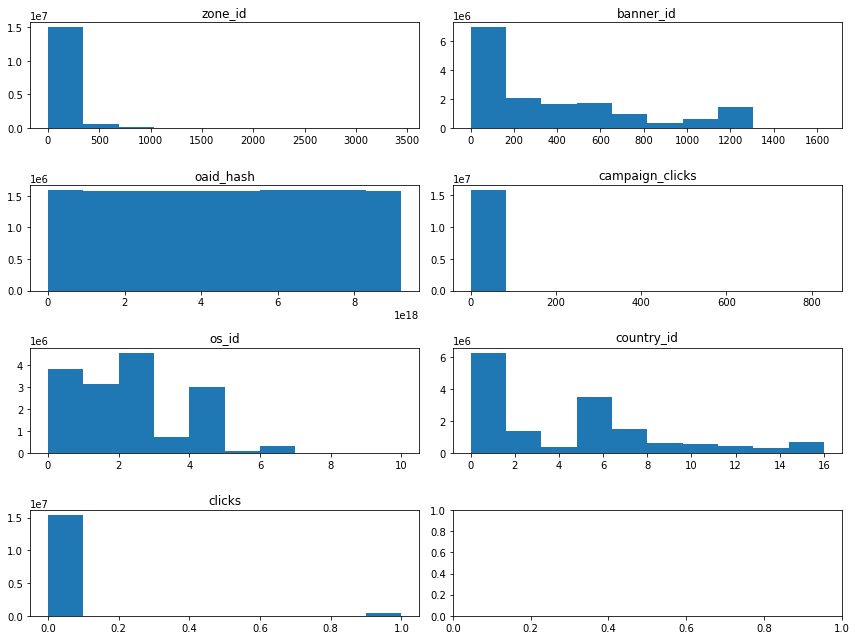

Матрица корреляции: 


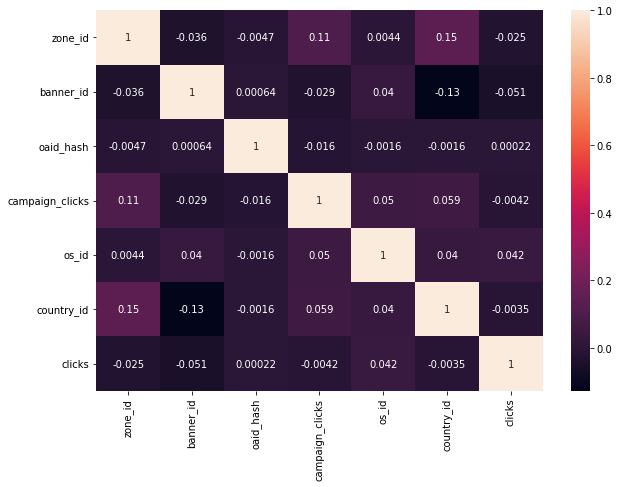

In [12]:
analysis(data)

В целом, т.к. у нас добавился лишь один признак - `oaid_hash` (который несет в себе информацию о хэше юзера), то мы можем сделать выводы, аналогичные первой работе



In [13]:
cleaned_data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1


In [14]:
val_size = 0.15

In [15]:
def train_test_val_split(data):
    last_year = data.date_time.max().year
    last_month = data.date_time.max().month
    last_day = data.date_time.max().day
    latest_data = pd.Timestamp(last_year, last_month, last_day)
    test_data = data[data.date_time >= latest_data]
    train_data = data[data.date_time < latest_data]
    train_data = train_data.drop(columns=['date_time'])
    test_data = test_data.drop(columns=['date_time'])
    val_data = train_data.iloc[int((1 - val_size) * len(train_data)) : ]
    train_data = train_data.iloc[ : int((1 - val_size) * len(train_data))]
    return train_data, val_data, test_data

In [16]:
def feature_engineering(data):
    scaler = StandardScaler()
    data.campaign_clicks = scaler.fit_transform(data.campaign_clicks.to_frame())
    data['zone_id'] = data['zone_id'].map(str)
    data['country_id'] = data['country_id'].map(str)
    data['banner_id'] = data['banner_id'].map(str)
    data['os_id'] = data['os_id'].map(str)
    data['oaid_hash'] = data['oaid_hash'].map(str)
    data['clicks'] = data['clicks']
    return train_test_val_split(data)

In [17]:
all_data = feature_engineering(cleaned_data)
train_data = all_data[0]
val_data = all_data[1]
test_data = all_data[2]
print(f'Train : {train_data.shape}')
print(f'Validation : {val_data.shape}')
print(f'Test : {test_data.shape}')

Train : (11638619, 7)
Validation : (2053875, 7)
Test : (2128978, 7)


In [18]:
val_data.head()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
13451042,133,465,1143585244764309153,-0.06745,2,5,0
13451043,19,946,4934163765402159102,-0.06745,0,3,0
13451044,1,188,8244126206353199924,-0.06745,2,15,0
13451045,17,617,850677064720759216,-0.06745,0,9,0
13451046,43,119,6549356529638895162,-0.06745,4,0,0


In [19]:
train_data.head()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
0,0,0,5664530014561852622,-0.067450,0,0,1
1,1,1,5186611064559013950,-0.067450,0,1,1
2,2,2,2215519569292448030,0.256904,0,0,1
3,3,3,6262169206735077204,-0.067450,1,1,1
4,4,4,4778985830203613115,-0.067450,1,0,1


### FFM

Для использования Field-aware Factorization Machine (FFM) - надстройка над FM (в FM добавляется взаимодействие фичей к линейной части) используется особый формат данных, в котором должно быть, кроме значения фичи и таргета, еще и значение поля - "тип" (группа), к которой относится конкретная фича (пользователь, рекламодатель и т.д.)

Имплементация перевода в формат libffm взята из https://www.kaggle.com/code/mpearmain/pandas-to-libffm, также будем использовать библиотеку `xlearn` для FFM

In [20]:
train_data.to_csv('train_data.csv', index=False)

In [21]:
val_data.to_csv('val.csv')
test_data.to_csv('test.csv')

In [22]:
class FFMFormatPandas:
    def __init__(self):
        self.field_index_ = None
        self.feature_index_ = None
        self.y = None

    def fit(self, df, y=None):
        self.y = y
        df_ffm = df[df.columns.difference([self.y])]
        if self.field_index_ is None:
            self.field_index_ = {col: i for i, col in enumerate(df_ffm)}

        if self.feature_index_ is not None:
            last_idx = max(list(self.feature_index_.values()))

        if self.feature_index_ is None:
            self.feature_index_ = dict()
            last_idx = 0

        for col in df.columns:
            vals = df[col].unique()
            for val in vals:
                if pd.isnull(val):
                    continue
                name = '{}_{}'.format(col, val)
                if name not in self.feature_index_:
                    self.feature_index_[name] = last_idx
                    last_idx += 1
            self.feature_index_[col] = last_idx
            last_idx += 1
        return self

    def fit_transform(self, df, y=None):
        self.fit(df, y)
        return self.transform(df)

    def transform_row_(self, row, t):
        ffm = []
        if self.y != None:
            ffm.append(str(row.loc[row.index == self.y][0]))
        if self.y is None:
            ffm.append(str(0))

        for col, val in row.loc[row.index != self.y].to_dict().items():
            col_type = t[col]
            name = '{}_{}'.format(col, val)
            if col_type.kind ==  'O':
                ffm.append('{}:{}:1'.format(self.field_index_[col], self.feature_index_[name]))
            elif col_type.kind == 'i':
                ffm.append('{}:{}:{}'.format(self.field_index_[col], self.feature_index_[col], val))
        return ' '.join(ffm)

    def transform(self, df):
        t = df.dtypes.to_dict()
        return pd.Series({idx: self.transform_row_(row, t) for idx, row in df.iterrows()})

In [23]:
ffm_train = FFMFormatPandas()
ffm_train_data = ffm_train.fit_transform(train_data, y='clicks')

In [24]:
ffm_train_data.to_csv('ffm_train.txt', index=False)

In [25]:
ffm_val_data = ffm_train.fit_transform(val_data, y='clicks')
ffm_test_data = ffm_train.fit_transform(test_data, y='clicks')

In [26]:
ffm_val_data.to_csv('ffm_val.txt', index=False)
ffm_test_data.to_csv('ffm_val.txt', index=False)

In [27]:
train_read_data = pd.read_csv('train_data.csv')
ffm_train = ffm_converter.fit_transform(train_read_data, y='clicks')

NameError: name 'ffm_converter' is not defined

In [ ]:
ffm_converter = FFMConverter()
ffm_val_data = ffm_converter.fit_transform(val_data, y='clicks')

Будем перебирать различные гиперпараметры для нашей FFM модели

In [ ]:
for k_i in [2, 4, 8]:
    for lambda_i in [0.1, 0.001]:
        params = {
            'task': 'binary',
            'lr': 0.1,
            'lambda': lambda_i,
            'k': k_i, 
            'metric': 'auc', 
            'epoch': 15
        }
        ffm_model = xl.create_ffm()
        ffm_model.setTrain("ffm_train.txt")
        ffm_model.setValidate("ffm_val.txt")
        ffm_model.fit(params, "model.out")